In [2]:
from scipy.stats import lognorm
import matplotlib.pyplot as plt
import numpy as np 
import Correlated_Poisson_Process as pp
import Plot as plot

In [3]:
plt.rcParams["axes.facecolor"] = 'white'
plt.rcParams["figure.facecolor"] = 'white'

# 1. Generate spike trains for neurons with higher-order correlations

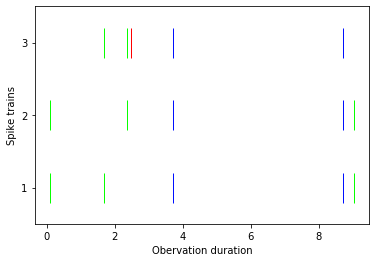

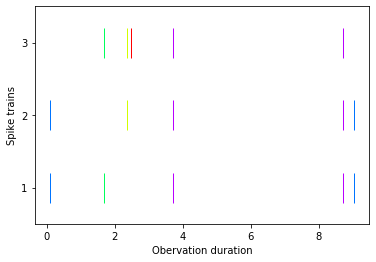

In [4]:
# generate parallel spikes with different rates
spike_trains = pp.generate_parallelST([0.2,0.2,0.4,0.4,0.4,0.2,0.1], 10) 
marked_process1 = pp.parallelST_to_markedProcess(spike_trains)
# reverse marked process to parallel spike trains. 
components = pp.markedProcess_to_components(marked_process1)

correlatedST1 = pp.markedProcess_to_correlatedST(marked_process1)

# generate marked process with list of rates
marked_process2 = pp.generate_markedProcess([0.2,0.2,0.2,0.4,0.4,0.4,0.8], 10)
correlatedST2 = pp.markedProcess_to_correlatedST(marked_process2)

# use rate distribution to generate marked process directly
marked_process3 = pp.direct_markedProcess([0.2,0.2,0.1,0.1,0.2,0.2,0.1], 10)
correlatedST3 = pp.markedProcess_to_correlatedST(marked_process3)


# plot corrleated poisson process. Same amplitude has same color'
plot.colorPlot_correlatedST(marked_process3, color_key='amplitudes')
# plot corrleated poisson process. Spikes coming from same component have same color.
# Color map can be changed, default is plt.cm.hsv
import matplotlib.pyplot as plt
plot.colorPlot_correlatedST(marked_process3, color_key='components',  )

# 2. Thinning process

## 2.1 Thinning a poissonian spike train

In [41]:
rate = 5       # rate (λ) of the target spike train
cv = 1.3       # coefficiant of variation (cv) of the target spike train
T = 10 
sigma = np.sqrt(np.log(cv**2 +1))             # analytical expression of σ
mu = -0.5 * np.log(rate**2 * (cv**2 +1))      # analytical expression of μ    

#define hazard function
def hazard(t):
    pdf = lognorm.pdf(t, sigma, np.exp(mu))
    sf = lognorm.sf(t, sigma, np.exp(mu))
    return pdf / sf

# define R_m, which is a bit greater than the peak value of hazard function.   
x = np.linspace(0, T, 300)
R_m = max(hazard(x)) * 1.1
print('R_m: ', R_m)

S = pp.generate_parallelST([R_m], T)[0] # stimulate a Poisson process with rate R_m
n = len(S)
U = np.random.uniform(0,R_m, n) # draw n random values between [0, R_m)
t_latest = S[0] 
new_S = [t_latest]
# For each spike draw a random value between [0, R_m). If the random value
# greater than the value of hazard function, reject the spike and continue
# the hazard function until the random value is no greater than the hazard 
# function. Then save the spike and reset the hazard function.
for i in range(1,n):
    if U[i] <= hazard([S[i]-t_latest]):
        t_latest = S[i]
        new_S.append(t_latest)
# print the number of spikes before and after thinning
print(len(S))
print(len(new_S))

R_m:  0.9259523621319626
13
10


## 2.2 Visualize the thinning process 

Text(0.5, 0, 'Observation duration')

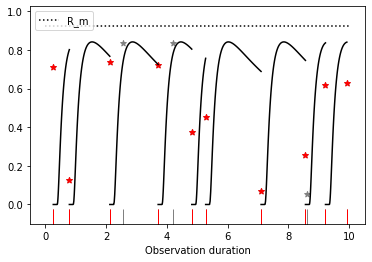

In [42]:
####plot the thinning process. Hazard function is not a monotonic. Grey spikes are rejected. Red spikes are kept.

plt.figure()
for i in range(len(new_S)-1):
    xs = np.linspace(new_S[i], new_S[i+1], 100)
    plt.plot(xs, hazard(xs-new_S[i]), c = 'k')
# plot the last part of harzard function, where it equals 0
x_tail = np.linspace(new_S[-1], S[-1], 50)
plt.plot(x_tail, hazard(x_tail-new_S[-1]), c = 'k')
# plot the spikes
y= np.empty(len(S))
y.fill(-0.1) 
y_new = np.empty(len(new_S))
y_new.fill(-0.1) 
new_U = U[S.searchsorted(new_S)] # find corresponding U for new_S
plt.scatter(S, U, marker = '*', c = 'gray')
plt.scatter(new_S, new_U, marker = '*', c = 'r')
plt.plot(S, y, marker = '|', linestyle = '', markersize=30, c = 'gray')
plt.plot(new_S, y_new, marker = '|', linestyle = '', markersize=30, c = 'r')
plt.plot(x, [R_m]*len(x), ':k', label = 'R_m')
plt.ylim(-0.1, R_m+0.1);
plt.legend(loc = "upper left")
plt.xlabel('Observation duration')


# 3. Validation
Stimulate a Poisson process and thin it. Plot the ISI distribution of newly generated spike train. Validate that it is the desired lognormal distribution.

In [57]:
rate = 40       # rate (λ) of the target spike train
cv = 0.2        # coefficiant of variation (cv) of the target spike train
T = 500 
sigma = np.sqrt(np.log(cv**2 +1))             # analytical expression of σ
mu = -0.5 * np.log(rate**2 * (cv**2 +1))      # analytical expression of μ

def hazard(t):
    pdf = lognorm.pdf(t, sigma, np.exp(mu)) # probability density function
    sf = lognorm.sf(t, sigma, np.exp(mu))   # survival function
    return pdf / sf

# define R_m, which is a bit greater than peak value of hazard function.
# With bigger R_m more spikes will be rejected. With smaller R_m, more 
# spikes will be kept, which makes an efficient thinning process.
x = np.linspace(0, T, 300)
R_m = max(hazard(x)) * 1.1 # magnification factor 1.1. It can be replaced.

S = pp.generate_parallelST([R_m], T)[0] # Poisson process with rate R_m
new_S = pp.thinning(S, rate, cv, T)

# print the number of spikes before and after thinning
print(len(S))
print(len(new_S))
isi_logn = np.diff(new_S)

5295
481


Text(0, 0.5, 'Histogram fraction')

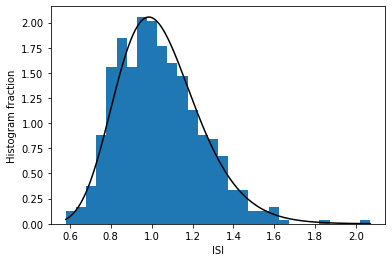

In [58]:
# plot the histogramm of ISI and the pdf curve 
plt.figure()
count, bins, ignored = plt.hist(isi_logn,30, density=True, align='mid')
xs = np.linspace(min(bins),max(bins), 300)
pdf =lognorm.pdf(xs, sigma, np.exp(mu))
plt.plot(xs, pdf, c = 'k')
plt.xlabel('ISI')
plt.ylabel('Histogram fraction')
